# Binary classification comparison
## Part 1: Variable selection and XGBoost

After succesfully defending my dissertation and finishing the subsequent required minor revisions, I was predictably mentally exhausted and sick of thinking about cortisol and analyzing small datasets with hierarchical linear modeling. After taking a few days off to do absolutely nothing, I decided I needed an analytic palate cleanser. For fun, I decided to compare binary classification performance of a bunch of machine learning algorithms using a fairly large dataset (insanely large by my biological human subjects research standards, though arguably still quite modest by industry standards). I ended up exploring the publicly available CDC Behavioral Risk Factor Surveillance System dataset. You can find the 2017 data and documentation <a href="https://www.cdc.gov/brfss/annual_data/annual_2017.html" target="_blank">here</a>.

Briefly, it contains ~450,000 records of a variety of self-reported health-related variables. A codebook is available that describes all 358 variables included in the sas data file. Cleaning up all that data was kind of arduous. I'm not going to document all my data preparation here, but if you're interested you can find the data cleaning/prep scripts I wrote over at my <a href="https://github.com/fiksdala/alexdatasci/tree/master/cdc_data_prep" target="_blank">github</a>. Fair warning, it's not pretty and is light on comments. Maybe I'll do a data cleaning post later where I'll clean up that code a little and explain everything, but that's a project for another day. What's relevant is that the raw dataset was cleaned in such a way that the extraneous variables were cut, US state labels were converted to other state-level variables of interest, observations with lots of missing data were removed, categorical variables were onehot encoded, continuous variables were standardized (not necessary for GXB, but helpful for other algorithms), and it was randomly split into training, validation, and test datasets.

First, I'll import the datasets and print the shape of each.

In [1]:
import pickle
# See the github link above for the scripts that cleaned the data and 
# saved these pickled files.
x_train = pickle.load( open( "x_train.pickle", "rb" ) )
x_val = pickle.load( open( "x_val.pickle", "rb" ) )
x_test = pickle.load( open( "x_test.pickle", "rb" ) )
y_train = pickle.load( open( "y_train.pickle", "rb" ) )
y_val = pickle.load( open( "y_val.pickle", "rb" ) )
y_test = pickle.load( open( "y_test.pickle", "rb" ) )

print('Training: ',x_train.shape,'\n'
     'Validation: ',x_val.shape,'\n'
     'Test: ',x_test.shape)

Training:  (265245, 66) 
Validation:  (66312, 66) 
Test:  (82890, 66)


This dataset contains a variety of variables related to health and behavioral risk factors for health. Arbitrarily, I decided to use blood pressure as my dependent variable. Specifically, the variable RFHYPE5, which corresponds to "Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional." BP was a fairly attractive target for this little project for a variety of reasons. First, it's fairly easy to see how identifying people who have a history of high blood pressure may be of interest to a variety of companies or organizations looking to identify individuals for health interventions, services, or products. Second, the distribution of responses in the dataset is good, with a roughly 60/40 split of no to yes and less than .5% missing cases (all missing cases were removed from the dataset). Finally, at first glance it looks like there are plenty of variables that may be useful in making predictions.

## Objective

The goal here is to pick a model that predicts blood pressure history with the best balance of precision and recall. I also want to pick a model that uses as few variables as possible without sacrificing too much predictive power.

## Models

Just for fun and practice, I'll compare the performance of a few types of models: XGBoost (trees), Support Vector Machine, Logistic Regression, and a simple Artificial Nerual Network. I'll also explore ensembles For this sort of problem--with a relatively small number of noisy predictors and lots of observations--I don't expect performance to vary much from model to model, but it's still a fun exercise. 

## Feature selection

Initial feature selection included filtering out some of the 350 variables that were not of interest. Specifically, I didn't include variables that only summarized study-related information (e.g., sequences, phone type, or weights). I also drops other variables
that I considered unnecessary or redundent at first glance:

'\_STSTR', '\_STRWT', '\_RAWRAKE', '\_WT2RAKE', '\_LLCPWT',  
'\_RFHLTH', '\_PHYS14D', '\_MENT14D', '\_IMPRACE', '\_PRACE1',
'\_MRACE1', '\_HISPANC', '\_RACE', '\_RACEG21', 
'\_AGEG5YR', '\_AGE65YR', '\_AGE_G', '\_RFSMOK3',
'\_CURECIG', '\_MISFRT1', '\_MISVEG1', '\_FRT16A', '\_VEG23A',
'\_FRUITE1', '\_VEGETE1', '\_PACAT1', '\_PA30021', '\_PASTAE1',
'\_RFSEAT2', '\_PSU'

Finally, I removed all pre-transformed (unusable in original format) or intermediate variables (i.e., computed by the cdc for the sole purpose of creating other variables).

I trained an initial XGBoost model on the remaining 66 variables to get a sense of what variables are important:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier, plot_importance
# Get dictionary of variable names and questions (see github link above
# for details)
v_and_q_dict = pickle.load( open( "data_import.pickle", 
                                 "rb" ) )['v_and_q_dict']

# Default setting work fine here (more on that later)
xgb_var_select = XGBClassifier()
xgb_var_select.fit(x_train,y_train)

# Make dataframe sorted of sorted variable importance
varimport = pd.DataFrame({'imp':xgb_var_select.feature_importances_},
                         index=x_train.columns).sort_values(['imp'],
                                                ascending=False)

Let's take a look at variable importance (ordered):

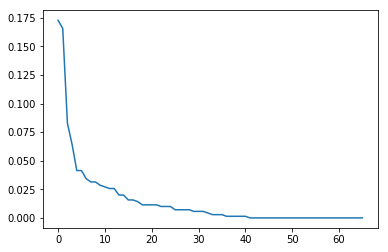

In [3]:
plt.plot(range(varimport.shape[0]),varimport)

Looks like only 40 variables contribute anything at all, with the top 5 or so doing the heavy lifting. Let's look at the variable names of the top 40:

In [4]:
# This is ugly because the variable/question dict was made before converting
# categoricals to onehot

var_name_importance = [(i,v_and_q_dict[i.split('_')[0]]) \
                       if len(i.split('_')[0])!=0 \
                       and i.split('_')[0] in v_and_q_dict \
                       else (i,v_and_q_dict['_'+i.split('_')[1]]) \
                       if len(i.split('_'))>2 and '_'+i.split('_')[1] \
                       in v_and_q_dict else (i,v_and_q_dict[i]) \
                       if i in v_and_q_dict else (i,i) \
                       for i in varimport.head(40).index]

Looking throught these variables, you can see there are a couple variables related to whether individuals have had their cholesterol checked or if they have asthma-related difficulties. I should have considered whether I wanted to include these variables, as they end up being sort of proxies for the dv. We may also be less interested in these types of variables because if we want to generalize these models they may not be as useful (if you know whether somebody's had their cholesterol checked, you probably already know their blood pressure status). I think the problem is more interesting without them, so I'll omit them going forward. 

One of my objectives was to create the simplest model possible. So how many variables should I include? I'll plot model accuracy of XGBoost by number of predictors (in order of importance) to help me decide (Model 0 is equivalent to a naive model, predicting 0 for every observation). Note: I'm using default values here, with the exception of n_estimators, which I've set at 250 (but I'm also using early stopping at 10 rounds to save time, so probably won't reach 250 anyway).

In [5]:
# Drop cholesterol/asthma variables, make list of variables to keep
# (in order of importance). Again, very ugly but gets the job done.
keep_vars = [i[0] for i in var_name_importance if i[0] not in \
             ['_MICHD_Did no','_CHOLCH1_1.0','_CHOLCH1_2.0','_LMTSCL1',
            '_LMTACT1','_ASTHMS1','_CHOLCH1_3.0','_RFCHOL1_Yes 15']]

# Get train and val error by number of predictors
train_er = []
val_er = []
for i in range(25):   
    rn=i
    nxgm = XGBClassifier(n_estimators=250,
                         max_depth=3,
                         random_state=1234)
    nxgm.fit(x_train[keep_vars[:rn]],
             y_train,
             eval_metric=['error'],
             eval_set=[(x_train[keep_vars[:rn]],y_train),
                      (x_val[keep_vars[:rn]],y_val)],
             early_stopping_rounds=10,verbose=False)
    train_er.append(nxgm.evals_result_['validation_0']['error'][-1])
    val_er.append(nxgm.evals_result_['validation_1']['error'][-1])

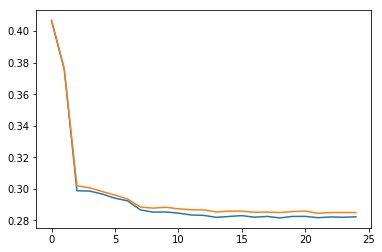

In [6]:
plt.plot(train_er)
plt.plot(val_er)

This plot tells us a couple things. First, performance on the training set (blue) isn't all that different than the validation set (orange). This tells us that there's not a lot of overfitting happening. This is not surprising given that the number of predictors is much smaller than the number of observations. This also means that hyperparameter tuning probably won't make a huge difference in model performance, at least in terms of overfitting. 

Second, the first couple variables (age and BMI) are really doing the heavy lifting here, and including more than the top 10 or so variables doesn't result in a very meaningful improvement in performance. Since my objective here is to create the best simplified model as possible, we'll just stick with the top 10 predictors for the rest of the models. On the other hand, if our objective depended on squeezing every ounce of predictive power out of the model, we might consider a different approach with more features.

## Hyperparameter tuning

Even though there doesn't appear to be much overfitting, it doesn't hurt to try a few hyperparameters to see how it affects performance. For now I'll just pick one (max_depth) and see how the model with the top 10 features performs with a set of possible values (Note: max_depth=1 is just a decision stump). I could use GridSearch with k-fold cross validation, but since I'm using a single validation set (for simplicity and to save time), I'll just code it myself.

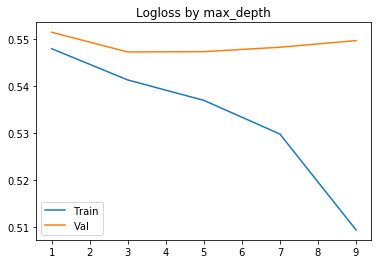

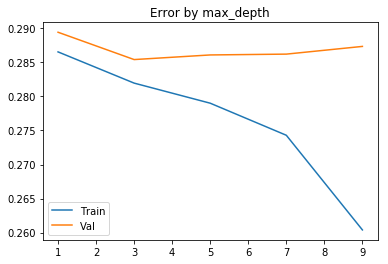

In [7]:
# Save top 10 variables
keep_vars10 = keep_vars[:10]

# Make a list of possible max_depth values:
md_vals = [1,3,5,7,9]

# Try each value, save logloss
m_list = []
for i in md_vals:
    nxgm = XGBClassifier(n_estimators=1000,
                         max_depth=i,
                         random_state=1234)
    nxgm.fit(x_train[keep_vars10],
             y_train,
             eval_metric=['error', 'logloss'],
             eval_set=[(x_train[keep_vars10],y_train),
                      (x_val[keep_vars10],y_val)],
             early_stopping_rounds=20,verbose=False)
    m_list.append(nxgm)

plt.plot(md_vals,
         [np.min(i.evals_result_['validation_0']['logloss']) for i in m_list])
plt.plot(md_vals,
        [np.min(i.evals_result_['validation_1']['logloss']) for i in m_list])
plt.title(label='Logloss by max_depth')
plt.legend(['Train', 'Val'])
plt.show()
plt.plot(md_vals,
         [np.min(i.evals_result_['validation_0']['error']) for i in m_list])
plt.plot(md_vals,
        [np.min(i.evals_result_['validation_1']['error']) for i in m_list])
plt.title(label='Error by max_depth')
plt.legend(['Train', 'Val'])
plt.show()

It's clear that the max_depth default value of 3 is the best choice for this problem. We could tinker with other hyperparamaters, but given that there isn't much overfitting (again, not surprising given n >> p) I don't see a need to add any regularization.

Now let's take a look at the confusion matrix for the model with max_depth=3:

In [8]:
xgb_unbal = m_list[1]
xgb_unbal_bnl = xgb_unbal.best_ntree_limit

xgb_unbal_pred_t = xgb_unbal.predict(x_train[keep_vars10],
                                     ntree_limit = xgb_unbal_bnl)
xgb_unbal_pred_v = xgb_unbal.predict(x_val[keep_vars10],
                                     ntree_limit = xgb_unbal_bnl)
print('Train')
print(confusion_matrix(y_train,xgb_unbal_pred_t))
print(classification_report(y_train,xgb_unbal_pred_t))

print('Validation')
print(confusion_matrix(y_val,xgb_unbal_pred_v))
print(classification_report(y_val,xgb_unbal_pred_v))

Train
[[120948  36484]
 [ 38358  69455]]
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.76    157432
         1.0       0.66      0.64      0.65    107813

   micro avg       0.72      0.72      0.72    265245
   macro avg       0.71      0.71      0.71    265245
weighted avg       0.72      0.72      0.72    265245

Validation
[[30068  9263]
 [ 9678 17303]]
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76     39331
         1.0       0.65      0.64      0.65     26981

   micro avg       0.71      0.71      0.71     66312
   macro avg       0.70      0.70      0.70     66312
weighted avg       0.71      0.71      0.71     66312



I'd say this model performs modestly better than chance, but I wouldn't call it great. With the sort of features we have (not individually very discriminate, fairly noisy), we probably can't expect stellar performance. One thing I didn't consider was class imbalance. Although not as serious a concern here as it might be for other problems where there is severe imbalance (like fraud detection), there are more 0s than 1s. I'll run the model again with the 'scale_pos_weight' parameter set to the ratio of 0 to 1 to account for the imbalance.

In [9]:
xgb_bal = XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1),
                   n_estimators=1000,
                   max_depth=3,
                   random_state=1234)

xgb_bal.fit(x_train[keep_vars10],
        y_train,
        eval_metric=['logloss'],
        eval_set=[(x_train[keep_vars10],y_train),
                  (x_val[keep_vars10],y_val)],
       early_stopping_rounds=20,verbose=False)


xgb_bal_bnl = xgb_bal.best_ntree_limit

xgb_bal_pred_t = xgb_bal.predict(x_train[keep_vars10],
                                     ntree_limit = xgb_bal_bnl)
xgb_bal_pred_v = xgb_bal.predict(x_val[keep_vars10],
                                     ntree_limit = xgb_bal_bnl)
print('Train')
print(confusion_matrix(y_train,xgb_bal_pred_t))
print(classification_report(y_train,xgb_bal_pred_t))

print('Validation')
print(confusion_matrix(y_val,xgb_bal_pred_v))
print(classification_report(y_val,xgb_bal_pred_v))

Train
[[104893  52539]
 [ 25035  82778]]
              precision    recall  f1-score   support

         0.0       0.81      0.67      0.73    157432
         1.0       0.61      0.77      0.68    107813

   micro avg       0.71      0.71      0.71    265245
   macro avg       0.71      0.72      0.71    265245
weighted avg       0.73      0.71      0.71    265245

Validation
[[26003 13328]
 [ 6323 20658]]
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.73     39331
         1.0       0.61      0.77      0.68     26981

   micro avg       0.70      0.70      0.70     66312
   macro avg       0.71      0.71      0.70     66312
weighted avg       0.72      0.70      0.71     66312



Taking class imbalance into account gives us a bit of a trade-off. Recall improves quite a bit, while precision goes down slightly. Choice of model here depends on priorities. Is it more important to capture as many people with a history of high blood pressure in your net as possible? Or is it really important that the people you predict have a history of high BP actually have that history? There's no right answer, but higher gain in recall relative to the drop in precision is notable. For now I'll save both models for later, and evaluate them with the test set once I've finished the other models. In my next post, I'll tackle the same problem with an SVM model.

In [10]:
pickle.dump(xgb_unbal, open('xgb_unbal.pickle', 'wb'))
pickle.dump(xgb_bal, open('xgb_bal.pickle', 'wb'))
pickle.dump(keep_vars10, open('keep_vars10.pickle', 'wb'))